# Deep Neural Networks
You should build an end-to-end machine learning pipeline using a deep learning model. In particular, you should do the following:
- Load the `fashion mnist` dataset from [TensorFlow](https://www.tensorflow.org/tutorials/keras/classification). The loaded dataset is already split into training and test sets.
- Build an end-to-end machine learning pipeline, including a [deep learning](https://www.tensorflow.org/tutorials/keras/classification) model.
- Optimize your pipeline by validating your design decisions.
- Test the best pipeline on the test set and report various [evaluation metrics](https://scikit-learn.org/0.15/modules/model_evaluation.html).  
- Check the documentation to identify the most important hyperparameters, attributes, and methods of the model. Use them in practice.

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

1. Load Fashion-MNIST dataset

In [4]:
df = pd.read_csv("/content/mnist.csv")
df.head()

,id,class,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,31953,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,34452,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,60897,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,36953,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1981,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Dataset is pre-split into train and test sets

In [5]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train: (60000, 28, 28) (60000,)
Test: (10000, 28, 28) (10000,)


2. Data Preprocessing

# Normalize pixel values from [0,255] to [0,1] for stability

In [6]:
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

# Flatten 28x28 images into 784-length vectors (for DNN input)

In [7]:
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

# Number of unique classes (10 categories: shoes, shirts, bags, etc.)

In [8]:
num_classes = len(np.unique(y_train))
print("Number of classes:", num_classes)

Number of classes: 10


3. Model Builder Function

# Builds different candidate DNN models for validation

In [18]:
def build_dnn(hidden_units=[256,128], dropout=0.3, lr=1e-3, batch_norm=False):
    model = keras.Sequential(name="DNN")
    model.add(layers.Input(shape=(784,)))


    #Add hidden layers

    for units in hidden_units:
        model.add(layers.Dense(units, activation="relu"))
        if batch_norm:
            model.add(layers.BatchNormalization())  # optional batch norm
        model.add(layers.Dropout(dropout))

     #Output layer: softmax for multi-class classification
        model.add(layers.Dense(num_classes, activation="softmax"))


    # Compile with Adam optimizer
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

4. Candidate Models for Validation

In [20]:
candidates = [
    {"name": "DNN_small", "hidden_units": [256,128], "dropout": 0.3, "lr": 1e-3, "batch_norm": False},
    {"name": "DNN_deeper", "hidden_units": [512,256,128], "dropout": 0.4, "lr": 8e-4, "batch_norm": False},
    {"name": "DNN_bn", "hidden_units": [512,256,128], "dropout": 0.4, "lr": 1e-3, "batch_norm": True},  # with BatchNorm
]

5. Training Configuration

In [21]:
BATCH_SIZE = 128
EPOCHS = 30

# Early stopping + LR scheduler to optimize training
callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy"),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, min_lr=1e-5, monitor="val_loss"),
]

6. Train and Validate Each Candidate

In [22]:
histories = {}
val_scores = {}
models = {}

for cfg in candidates:
    print(f"\n=== Training {cfg['name']} ===")
    model = build_dnn(cfg["hidden_units"], cfg["dropout"], cfg["lr"], cfg["batch_norm"])

    history = model.fit(
        X_train, y_train,
        validation_split=0.1,   # 10% of train set for validation
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=2,
    )

    best_val_acc = max(history.history["val_accuracy"])
    histories[cfg["name"]] = history
    val_scores[cfg["name"]] = best_val_acc
    models[cfg["name"]] = model

    print(f"{cfg['name']} best validation accuracy: {best_val_acc:.4f}")

# Select best model based on validation accuracy
best_name = max(val_scores, key=val_scores.get)
best_model = models[best_name]
print(f"\n✅ Best model selected: {best_name} (val_acc={val_scores[best_name]:.4f})")


=== Training DNN_small ===
Epoch 1/30
422/422 - 5s - 13ms/step - accuracy: 0.7764 - loss: 0.6343 - val_accuracy: 0.8463 - val_loss: 0.4103 - learning_rate: 1.0000e-03
Epoch 2/30
422/422 - 3s - 7ms/step - accuracy: 0.8410 - loss: 0.4424 - val_accuracy: 0.8612 - val_loss: 0.3766 - learning_rate: 1.0000e-03
Epoch 3/30
422/422 - 3s - 7ms/step - accuracy: 0.8553 - loss: 0.3989 - val_accuracy: 0.8700 - val_loss: 0.3561 - learning_rate: 1.0000e-03
Epoch 4/30
422/422 - 6s - 14ms/step - accuracy: 0.8616 - loss: 0.3792 - val_accuracy: 0.8732 - val_loss: 0.3524 - learning_rate: 1.0000e-03
Epoch 5/30
422/422 - 5s - 11ms/step - accuracy: 0.8697 - loss: 0.3585 - val_accuracy: 0.8792 - val_loss: 0.3326 - learning_rate: 1.0000e-03
Epoch 6/30
422/422 - 3s - 7ms/step - accuracy: 0.8749 - loss: 0.3466 - val_accuracy: 0.8770 - val_loss: 0.3340 - learning_rate: 1.0000e-03
Epoch 7/30
422/422 - 3s - 8ms/step - accuracy: 0.8754 - loss: 0.3359 - val_accuracy: 0.8800 - val_loss: 0.3346 - learning_rate: 1.0000e

7. Plot Training Curves

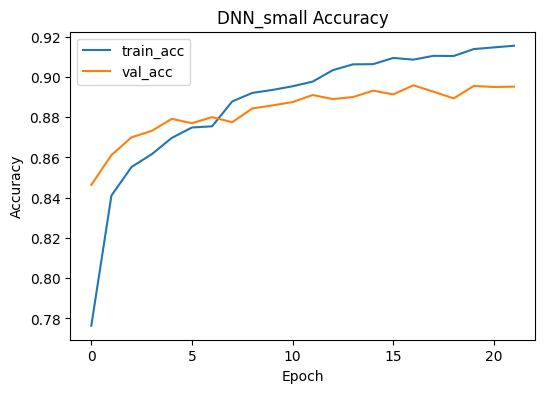

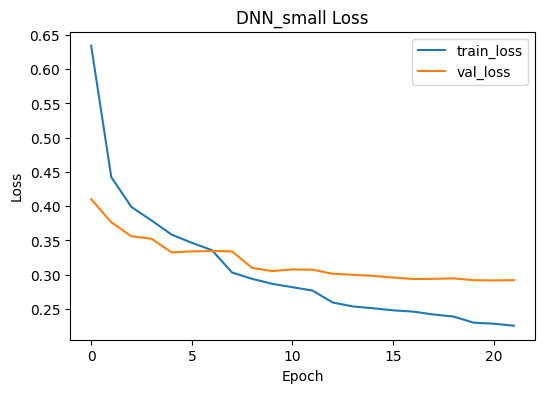

In [23]:
def plot_history(h, name):
    plt.figure(figsize=(6,4))
    plt.plot(h.history["accuracy"], label="train_acc")
    plt.plot(h.history["val_accuracy"], label="val_acc")
    plt.title(f"{name} Accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(h.history["loss"], label="train_loss")
    plt.plot(h.history["val_loss"], label="val_loss")
    plt.title(f"{name} Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

plot_history(histories[best_name], best_name)

8. Final Evaluation on Test Set


📊 Test Accuracy: 0.8912
📊 Test F1 (macro): 0.8910

Classification Report:
               precision    recall  f1-score   support

           0     0.8305    0.8380    0.8342      1000
           1     0.9928    0.9690    0.9808      1000
           2     0.7990    0.8310    0.8147      1000
           3     0.8968    0.8950    0.8959      1000
           4     0.8002    0.8290    0.8143      1000
           5     0.9817    0.9680    0.9748      1000
           6     0.7267    0.6780    0.7015      1000
           7     0.9472    0.9680    0.9575      1000
           8     0.9731    0.9780    0.9756      1000
           9     0.9628    0.9580    0.9604      1000

    accuracy                         0.8912     10000
   macro avg     0.8911    0.8912    0.8910     10000
weighted avg     0.8911    0.8912    0.8910     10000



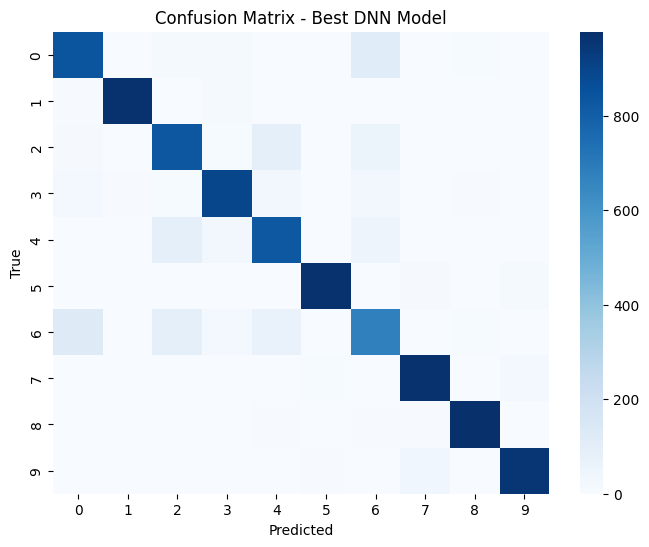

In [24]:
# Predict test labels
y_pred_probs = best_model.predict(X_test, batch_size=BATCH_SIZE, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Accuracy & F1-score
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average="macro")

print(f"\n📊 Test Accuracy: {acc:.4f}")
print(f"📊 Test F1 (macro): {f1_macro:.4f}\n")

# Detailed classification report
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=False, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Best DNN Model")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

10. Make Predictions & Visualize Results

In [28]:
# Use the best_model to predict probabilities
y_pred_probs = best_model.predict(X_test, batch_size=BATCH_SIZE, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

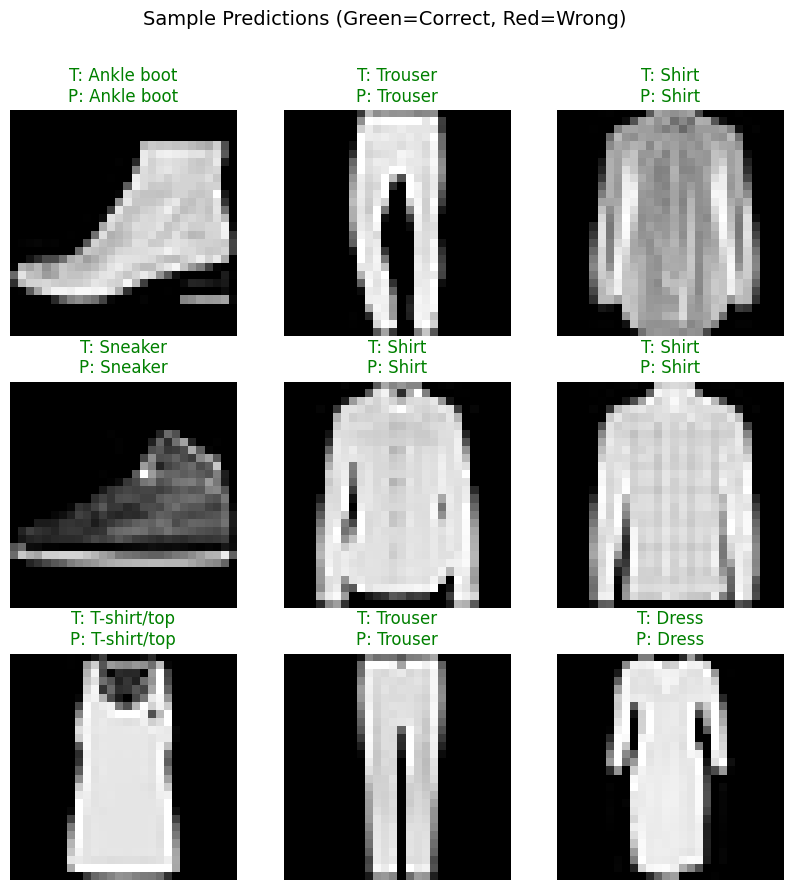

In [29]:
# Define class names for Fashion-MNIST
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Pick some random indices to visualize
num_images = 9
indices = random.sample(range(len(X_test)), num_images)

plt.figure(figsize=(10,10))

for i, idx in enumerate(indices):
    plt.subplot(3,3,i+1)
    img = X_test[idx].reshape(28,28)  # reshape back from 784 -> 28x28

    plt.imshow(img, cmap="gray")
    plt.axis("off")

    true_label = class_names[y_test[idx]]
    pred_label = class_names[y_pred[idx]]

    color = "green" if y_test[idx] == y_pred[idx] else "red"
    plt.title(f"T: {true_label}\nP: {pred_label}", color=color)

plt.suptitle("Sample Predictions (Green=Correct, Red=Wrong)", fontsize=14)
plt.show()

9. Saving the Best Model / Keras Format


In [30]:
# Save in the new Keras format (.keras)
best_model.save("best_fashion_mnist_dnn.keras")
print("\n💾 Best model saved as best_fashion_mnist_dnn.keras")


💾 Best model saved as best_fashion_mnist_dnn.keras


✅ These are all the steps:

Load dataset (Fashion-MNIST via TensorFlow).

Preprocessing (normalize + reshape).

Model builder (flexible DNN with dropout + optional BatchNorm).

Validation step with multiple candidate architectures.

Callbacks (EarlyStopping, ReduceLROnPlateau).

Training histories stored and best model automatically selected.

Visualization of learning curves (accuracy & loss).

Final evaluation with accuracy, F1, classification report, confusion matrix.